In [51]:
from datasets import load_dataset, load_metric
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras import Sequential, layers, regularizers
from keras.layers import Input, Dense,Conv2D , MaxPooling2D, Flatten,BatchNormalization,Dropout
import keras
from sklearn.metrics import classification_report , confusion_matrix , accuracy_score , auc


In [6]:
data_dir = r"C:\Users\Jan\SGH\magisterka\test_model2\2750"

In [7]:
batch_size = 24
img_height = 224
img_width = 224

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 27000 files belonging to 10 classes.
Using 24300 files for training.


In [9]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 27000 files belonging to 10 classes.
Using 2700 files for validation.


In [11]:
class_names = train_ds.class_names
print(class_names)

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


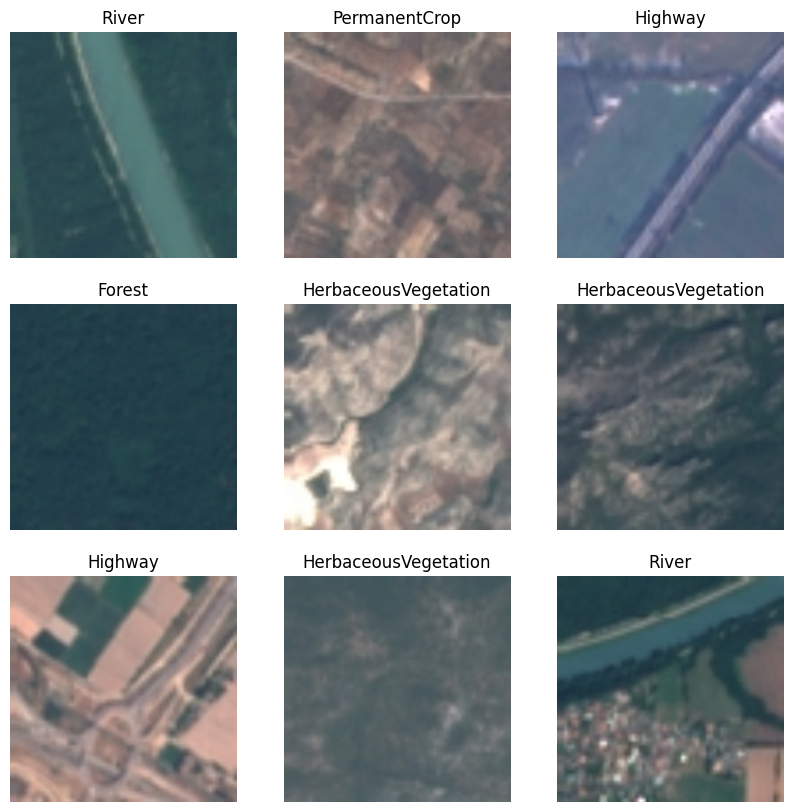

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [14]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.15368159 1.0


In [15]:
print(tf.__version__)

2.8.3


In [16]:
resize_and_rescale = keras.Sequential(
    [
        layers.Rescaling(1.0 / 255), 
        layers.Resizing(img_height, img_width),
    ],
    name = "resize_and_rescale"
)


In [17]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomContrast(0.8, 1.2),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)


In [18]:
base_model = hub.KerasLayer("https://www.kaggle.com/models/google/efficientnet-v2/frameworks/TensorFlow2/variations/imagenet1k-b0-classification/versions/2", input_shape=(224,224,3), trainable=True)

In [19]:
model = Sequential()
model.add(resize_and_rescale)
model.add(data_augmentation)
model.add(base_model)
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(class_names), activation='softmax'))

In [20]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [21]:
physical_devices = tf.config.list_physical_devices('GPU')
# if len(physical_devices) > 0:
#     tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [22]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [23]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [24]:
epochs = 50

In [25]:
# early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)

In [26]:
history = model.fit(
    train_ds,
    epochs= epochs,
    validation_data=val_ds,
#     callbacks=[early_stopping_callback]
)

Epoch 1/50
1013/1013 [==============================] - 84s 66ms/step - loss: 0.5154 - accuracy: 0.8457 - val_loss: 0.1895 - val_accuracy: 0.9496
Epoch 2/50
1013/1013 [==============================] - 65s 64ms/step - loss: 0.3110 - accuracy: 0.9083 - val_loss: 0.2281 - val_accuracy: 0.9304
Epoch 3/50
1013/1013 [==============================] - 66s 65ms/step - loss: 0.2716 - accuracy: 0.9217 - val_loss: 0.1653 - val_accuracy: 0.9504
Epoch 4/50
1013/1013 [==============================] - 65s 64ms/step - loss: 0.2620 - accuracy: 0.9249 - val_loss: 0.1967 - val_accuracy: 0.9370
Epoch 5/50
1013/1013 [==============================] - 66s 65ms/step - loss: 0.2562 - accuracy: 0.9242 - val_loss: 0.1741 - val_accuracy: 0.9422
Epoch 6/50
1013/1013 [==============================] - 66s 65ms/step - loss: 0.2406 - accuracy: 0.9316 - val_loss: 0.1139 - val_accuracy: 0.9667
Epoch 7/50
1013/1013 [==============================] - 66s 65ms/step - loss: 0.2286 - accuracy: 0.9334 - val_loss: 0.1389 -

In [27]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs_range = range(epochs)

# plt.figure(figsize=(8, 8))
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()

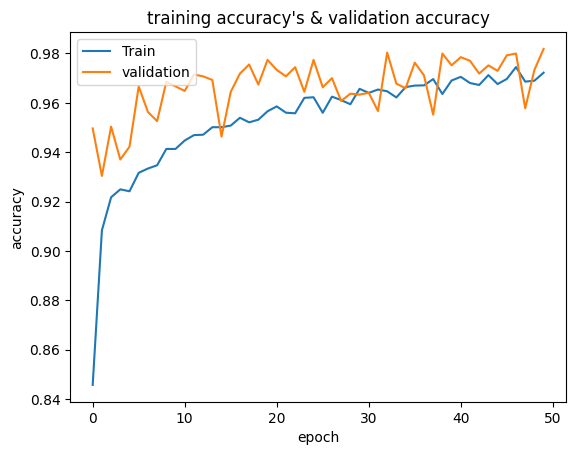

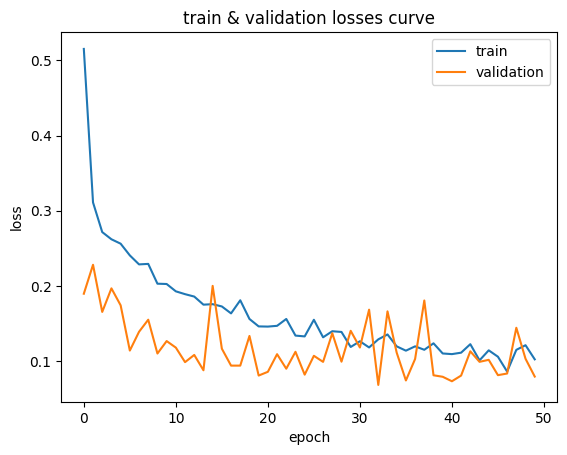

In [28]:
import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("training accuracy's & validation accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(["Train" ,"validation"],loc="upper left")
plt.show()

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("train & validation losses curve")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train", "validation"],loc="upper right")
plt.show()

In [29]:
# # evaluation
# loss ,acc = model.evaluate(train_ds)
# print("Accuracy on Train Data:",acc)
# print()
# loss ,acc = model.evaluate(val_ds)
# print("Accuracy on Test Data:",acc)

In [30]:
# y_pred = model.predict(val_ds)
# y_pred_test = [np.argmax(i) for i in y_pred]


In [31]:
# len(y_pred_test)

In [32]:
model.save("./saved_models/efficientnet_v2_ft1")

INFO:tensorflow:Assets written to: ./saved_models/efficientnet_v2_ft1\assets


INFO:tensorflow:Assets written to: ./saved_models/efficientnet_v2_ft1\assets


In [33]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt

def get_predictions_and_labels(model, dataset):
    all_predictions = []
    all_labels = []
    
    for images, labels in dataset:
        predictions = model.predict(images)
        predicted_labels = np.argmax(predictions, axis=1)
        all_predictions.extend(predicted_labels)
        all_labels.extend(labels.numpy())

    return all_predictions, all_labels

# Uzyskaj przewidywania i etykiety dla zbiorów treningowego i walidacyjnego
train_predictions, train_labels = get_predictions_and_labels(model, train_ds)
val_predictions, val_labels = get_predictions_and_labels(model, val_ds)


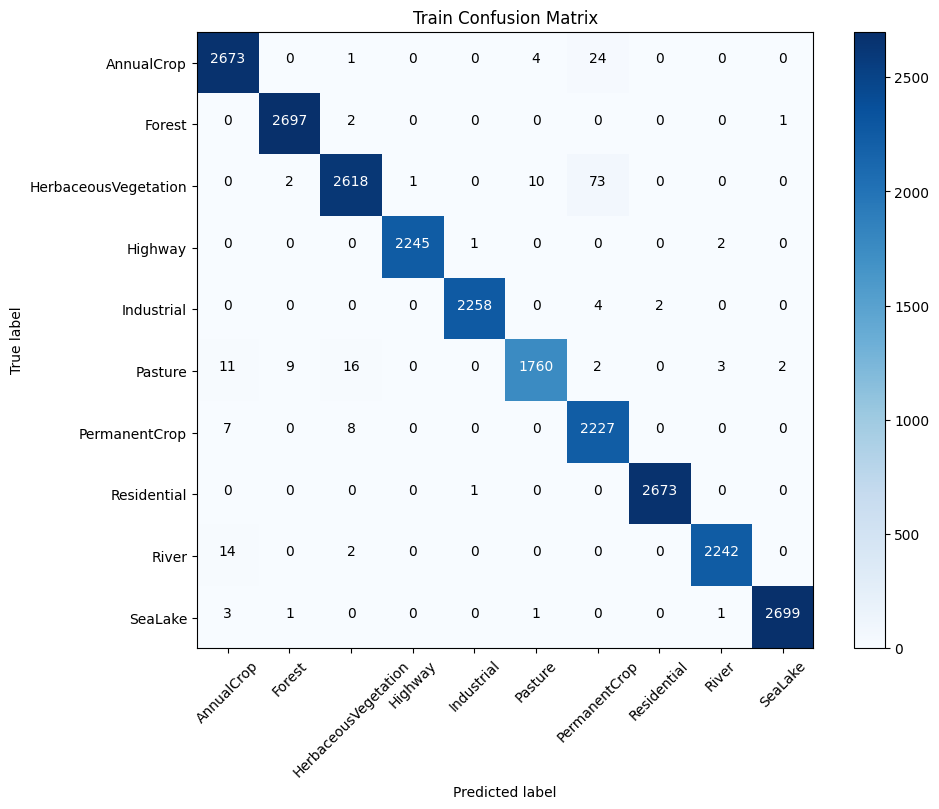

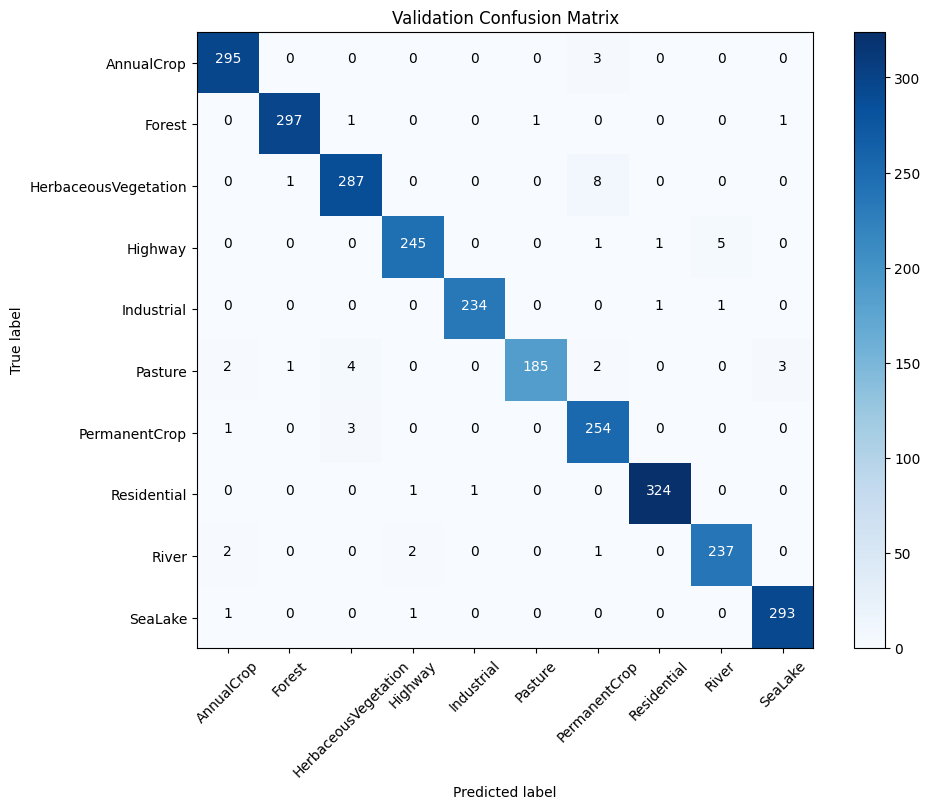

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', figsize=(10, 8)):
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Tworzenie i wyświetlanie macierzy pomyłek
cm_train = confusion_matrix(train_labels, train_predictions)
cm_val = confusion_matrix(val_labels, val_predictions)
class_names = val_ds.class_names  # Zastąp odpowiednimi nazwami klas
plot_confusion_matrix(cm_train, class_names, 'Train Confusion Matrix')
plot_confusion_matrix(cm_val, class_names, 'Validation Confusion Matrix')


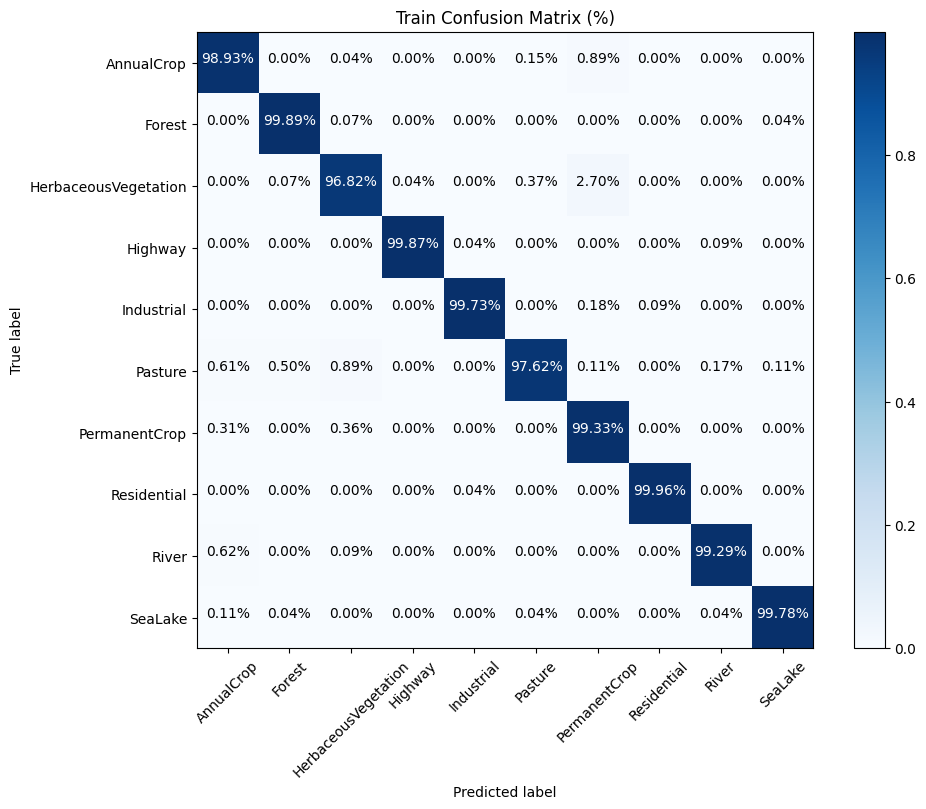

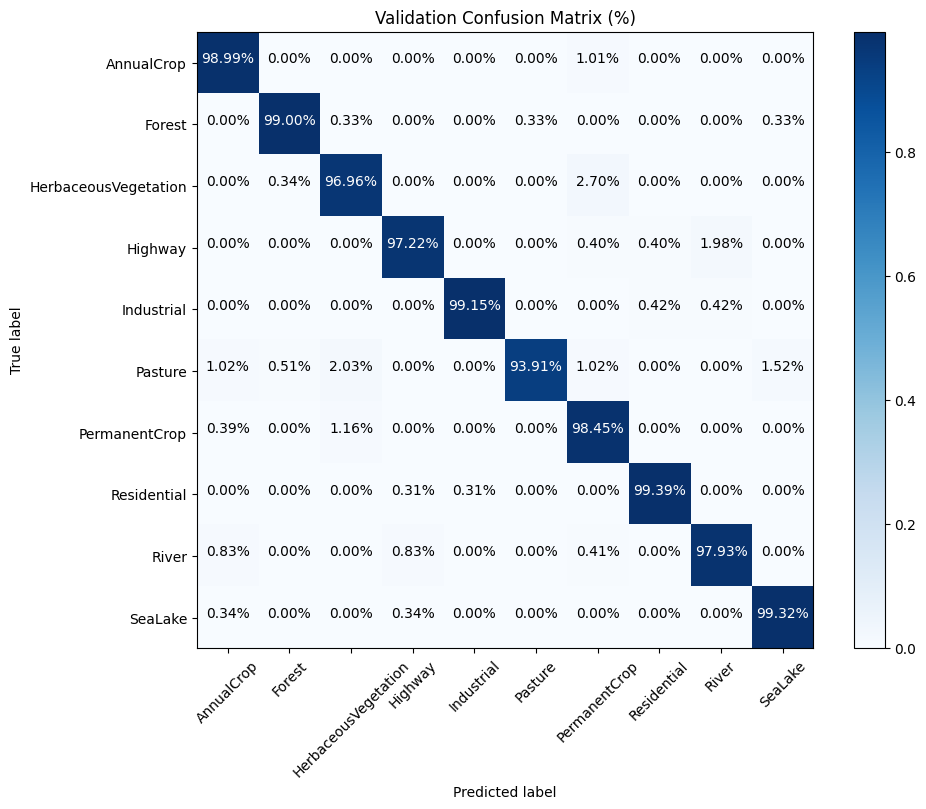

In [48]:
def plot_confusion_matrix_percent(cm, classes, title='Confusion Matrix (%)', figsize=(10, 8)):
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=figsize)
    plt.imshow(cm_percent, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm_percent.max() / 2.
    for i, j in itertools.product(range(cm_percent.shape[0]), range(cm_percent.shape[1])):
        plt.text(j, i, f"{cm_percent[i, j]:.2%}",
                 horizontalalignment="center",
                 color="white" if cm_percent[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
# Wyświetlanie procentowej macierzy pomyłek
plot_confusion_matrix_percent(cm_train, class_names, 'Train Confusion Matrix (%)')
plot_confusion_matrix_percent(cm_val, class_names, 'Validation Confusion Matrix (%)')


In [74]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resize_and_rescale (Sequent  (None, 224, 224, 3)      0         
 ial)                                                            
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 keras_layer (KerasLayer)    (None, 1000)              7200312   
                                                                 
 dense (Dense)               (None, 256)               256256    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               6

In [75]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def calculate_metrics(true_labels, predicted_labels):
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='macro')
    recall = recall_score(true_labels, predicted_labels, average='macro')
    f1 = f1_score(true_labels, predicted_labels, average='macro')

    return accuracy, precision, recall, f1

# Oblicz metryki dla zbioru treningowego
train_accuracy, train_precision, train_recall, train_f1 = calculate_metrics(train_labels, train_predictions)

# Oblicz metryki dla zbioru walidacyjnego
val_accuracy, val_precision, val_recall, val_f1 = calculate_metrics(val_labels, val_predictions)

print("Training Metrics:")
print(f"Accuracy: {train_accuracy}")
print(f"Precision: {train_precision}")
print(f"Recall: {train_recall}")
print(f"F1 Score: {train_f1}")

print("\nValidation Metrics:")
print(f"Accuracy: {val_accuracy}")
print(f"Precision: {val_precision}")
print(f"Recall: {val_recall}")
print(f"F1 Score: {val_f1}")

Training Metrics:
Accuracy: 0.991440329218107
Precision: 0.991317595857387
Recall: 0.9912149070190293
F1 Score: 0.99121199796759

Validation Metrics:
Accuracy: 0.9818518518518519
Precision: 0.982050649503891
Recall: 0.9803281757532026
F1 Score: 0.9810591186356312


## Model z L2, learning rate decay, większym dropout, 0,01 LR

In [70]:
model2 = Sequential()
model2.add(resize_and_rescale)
model2.add(data_augmentation)
model2.add(base_model)
model2.add(Dense(256,activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
model2.add(Dropout(0.3))
model.add(Dense(256,activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
model2.add(Dropout(0.3))
model2.add(Dense(len(class_names), activation='softmax'))

In [71]:
initial_learning_rate = 0.001
decay_steps = 1013 * 5  
decay_rate = 0.99  

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True) 

In [72]:
model2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [73]:
history = model2.fit(
    train_ds,
    epochs= epochs,
    validation_data=val_ds,
#     callbacks=[early_stopping_callback]
)

Epoch 1/50
1013/1013 [==============================] - 71s 66ms/step - loss: 2.1391 - accuracy: 0.2088 - val_loss: 1.5419 - val_accuracy: 0.4263
Epoch 2/50
1013/1013 [==============================] - 66s 65ms/step - loss: 1.4382 - accuracy: 0.4668 - val_loss: 0.8362 - val_accuracy: 0.7241
Epoch 3/50
1013/1013 [==============================] - 66s 65ms/step - loss: 0.9997 - accuracy: 0.6567 - val_loss: 0.6093 - val_accuracy: 0.7896
Epoch 4/50
1013/1013 [==============================] - 66s 65ms/step - loss: 0.8116 - accuracy: 0.7357 - val_loss: 0.5358 - val_accuracy: 0.8304
Epoch 5/50
1013/1013 [==============================] - 68s 67ms/step - loss: 0.6834 - accuracy: 0.7830 - val_loss: 0.4607 - val_accuracy: 0.8581
Epoch 6/50
1013/1013 [==============================] - 69s 68ms/step - loss: 0.5855 - accuracy: 0.8229 - val_loss: 0.3760 - val_accuracy: 0.8900
Epoch 7/50
1013/1013 [==============================] - 67s 66ms/step - loss: 0.5046 - accuracy: 0.8488 - val_loss: 0.2985 -

In [76]:
# Uzyskaj przewidywania i etykiety dla zbiorów treningowego i walidacyjnego
train_predictions2, train_labels2 = get_predictions_and_labels(model2, train_ds)
val_predictions2, val_labels2 = get_predictions_and_labels(model2, val_ds)



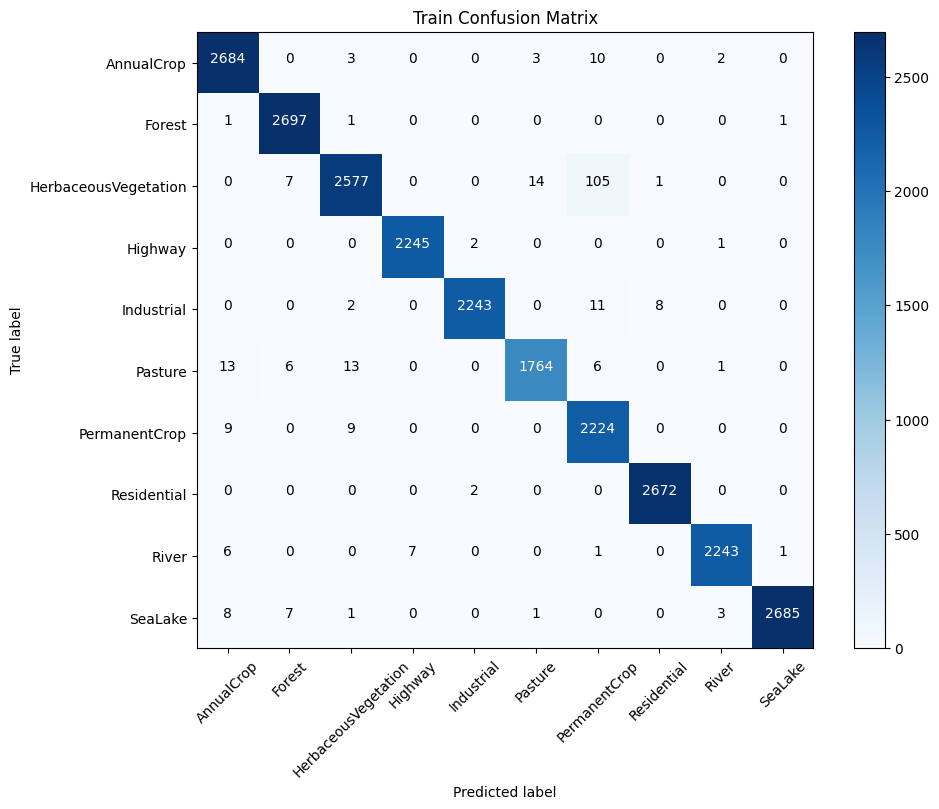

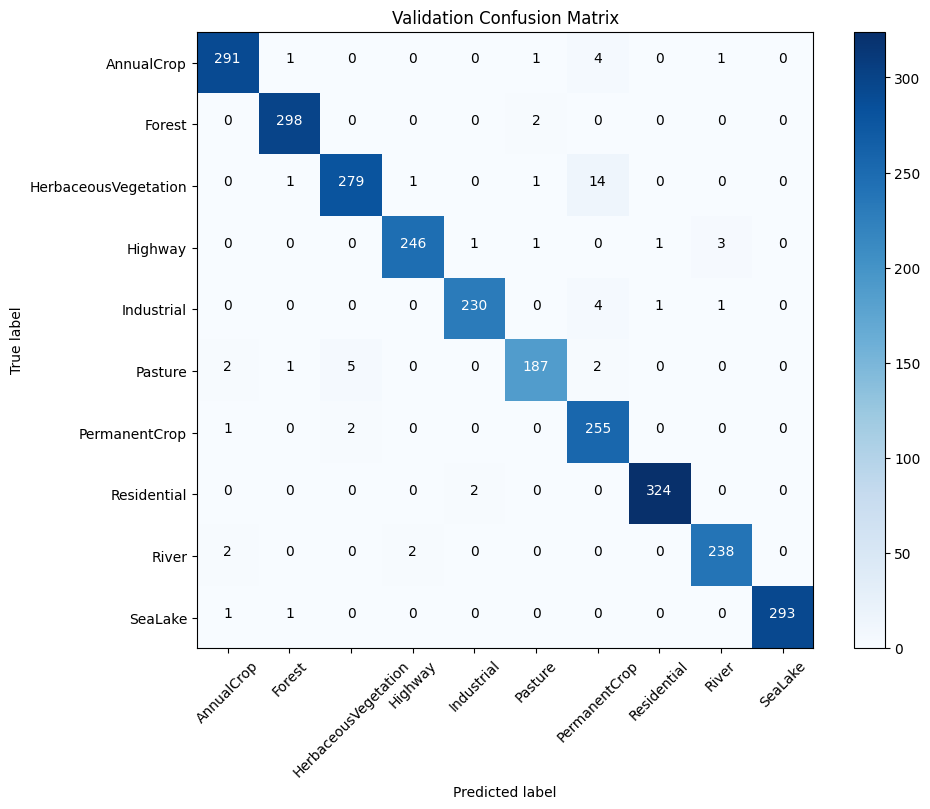

In [77]:
# Tworzenie i wyświetlanie macierzy pomyłek
cm_train2 = confusion_matrix(train_labels2, train_predictions2)
cm_val2 = confusion_matrix(val_labels2, val_predictions2)
class_names = val_ds.class_names  # Zastąp odpowiednimi nazwami klas
plot_confusion_matrix(cm_train2, class_names, 'Train Confusion Matrix')
plot_confusion_matrix(cm_val2, class_names, 'Validation Confusion Matrix')

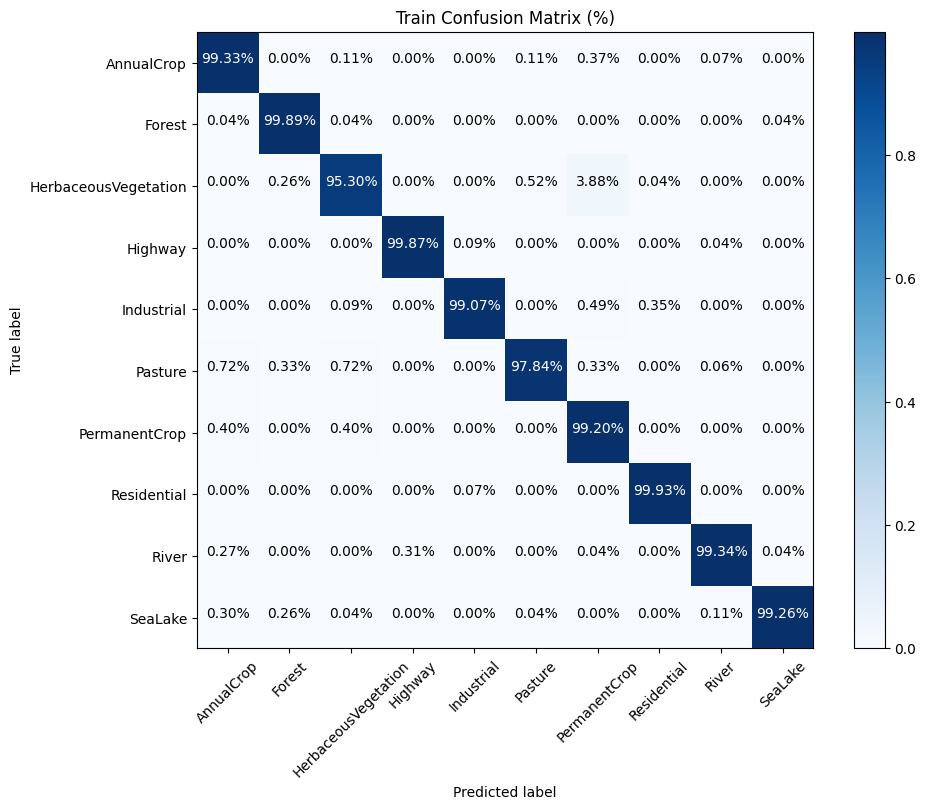

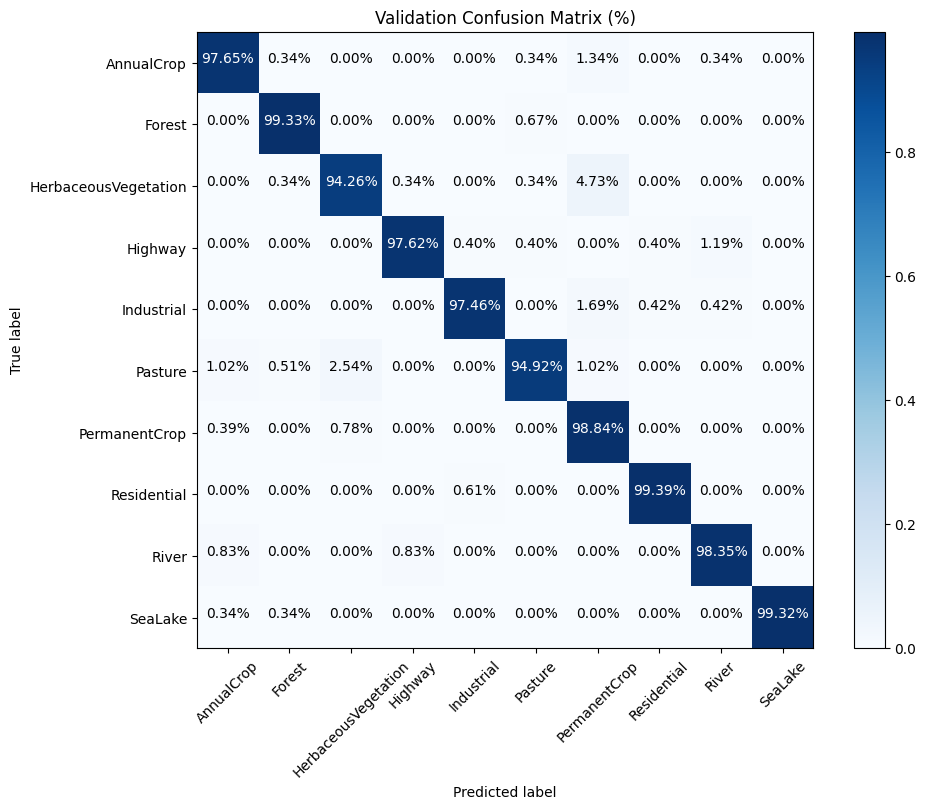

In [78]:
# Wyświetlanie procentowej macierzy pomyłek
plot_confusion_matrix_percent(cm_train2, class_names, 'Train Confusion Matrix (%)')
plot_confusion_matrix_percent(cm_val2, class_names, 'Validation Confusion Matrix (%)')

In [79]:
model2.save("./saved_models/efficientnet_v2_ft2")

INFO:tensorflow:Assets written to: ./saved_models/efficientnet_v2_ft2\assets


INFO:tensorflow:Assets written to: ./saved_models/efficientnet_v2_ft2\assets
